In [20]:
import openai
import numpy as np
#PUT api key from your OpenAI account
openai.api_key = "your api key here"

In [3]:
#class list
# note: replace with actual classes
class_labels = {'forest': np.array([255, 0, 0]), 
                'buildings': np.array([0, 255, 0]), 
                'lake':np.array([0, 0, 255]), 
                'land':np.array([128, 0, 128])}

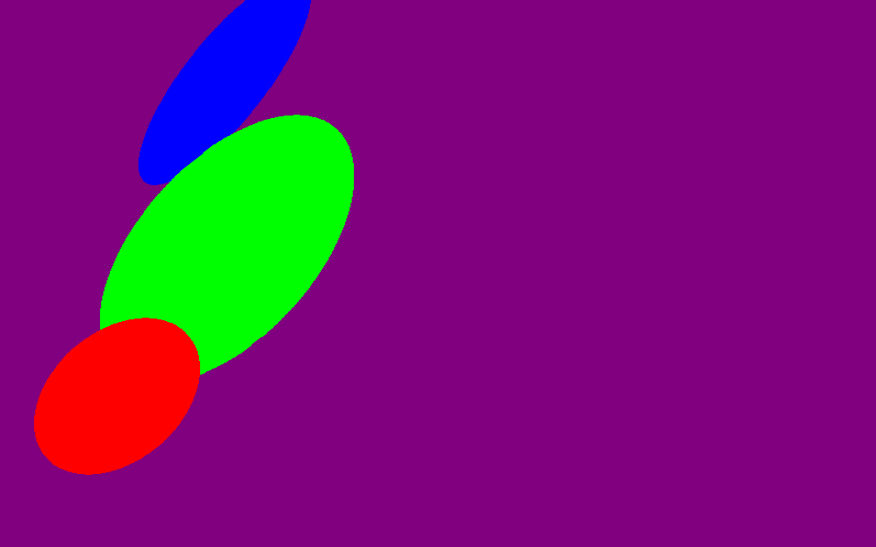

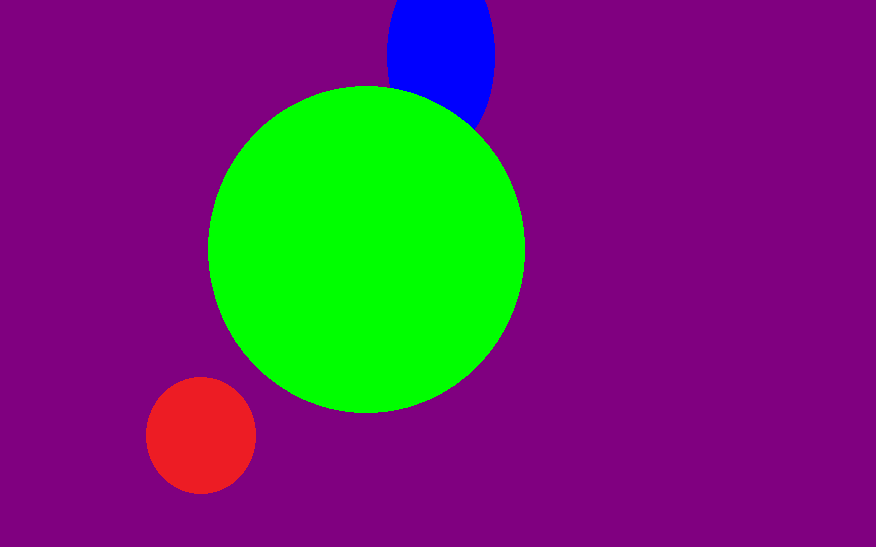

In [11]:
import cv2
from google.colab.patches import cv2_imshow

img1 = cv2.imread('before1.png')
img2 = cv2.imread('after1.png')
# Resize the images to the same size
img1 = cv2.resize(img1, (img2.shape[1], img2.shape[0]))
cv2_imshow(img1)
cv2_imshow(img2)

[[  0   0 255]
 [  0 255   0]
 [128   0 128]
 [255   0   0]]
(4, 3)


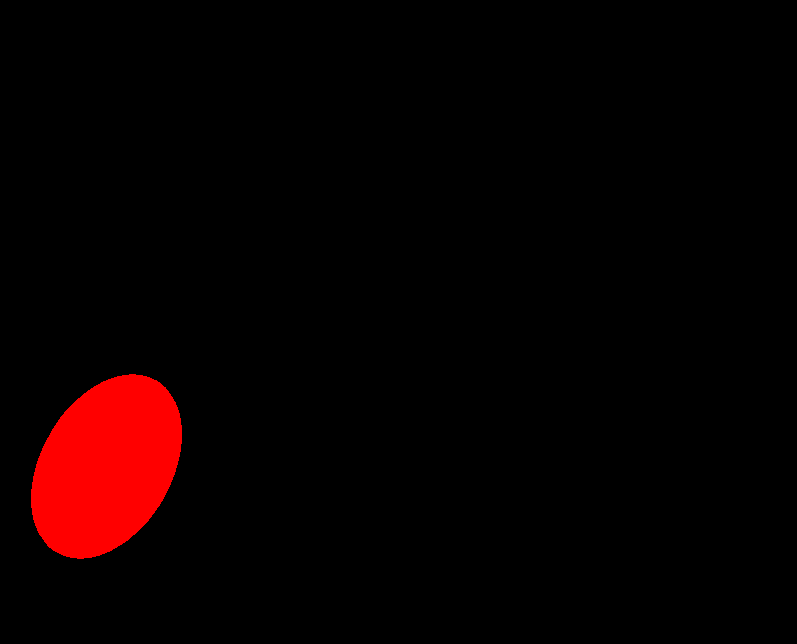

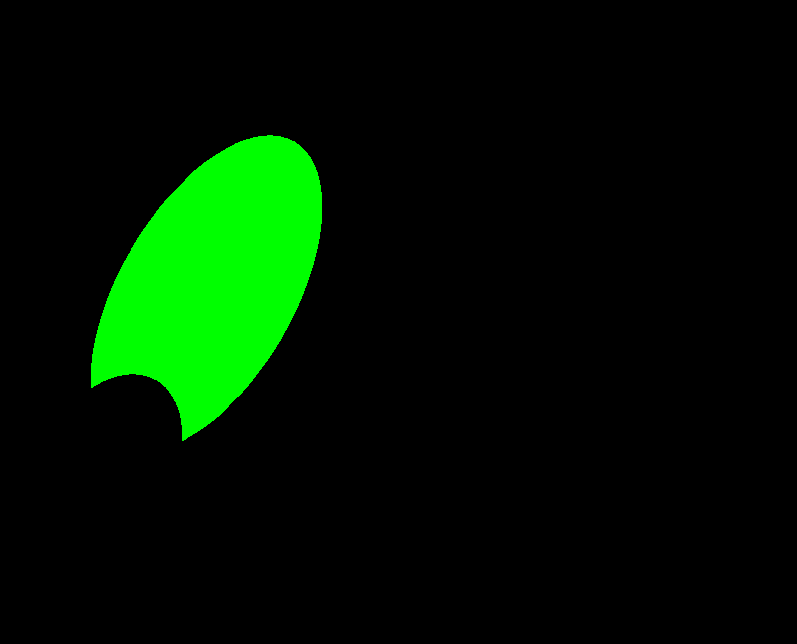

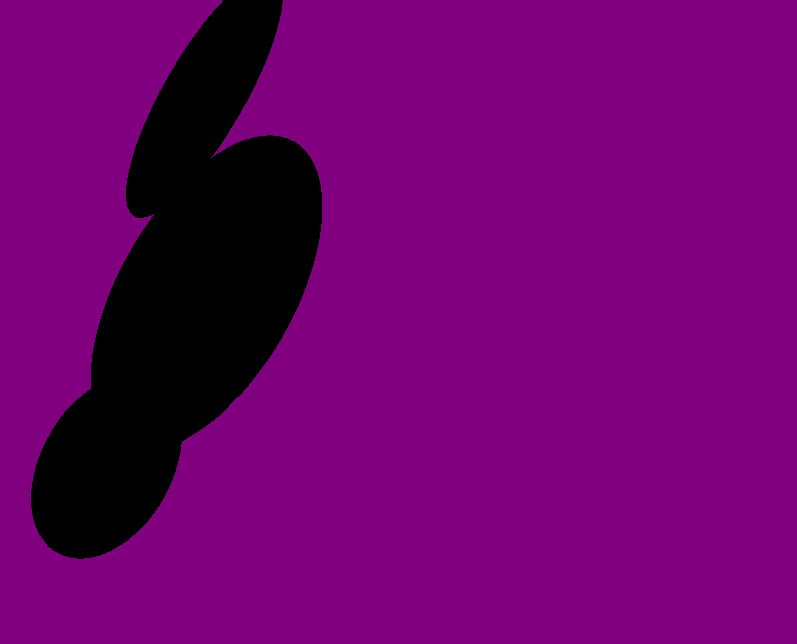

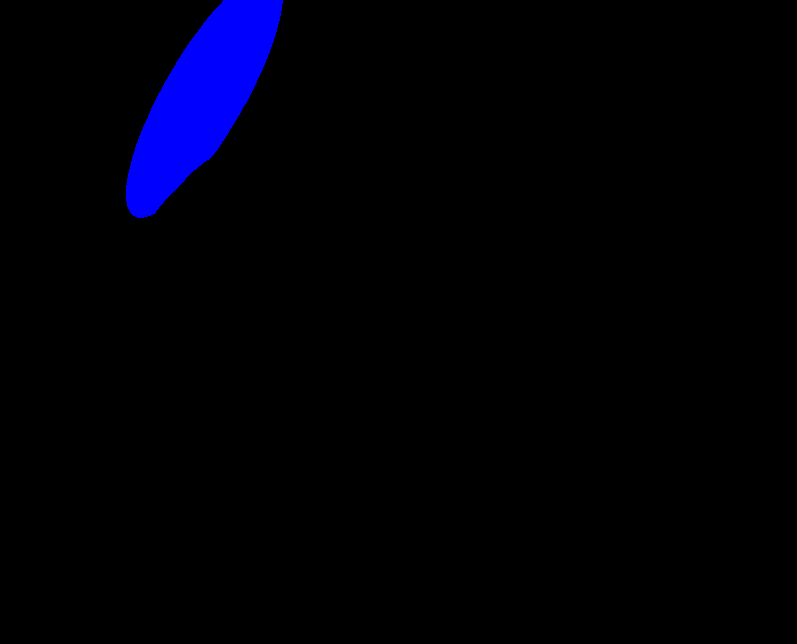

In [8]:
img = cv2.imread('before1.png')

# Convert the image to the RGB color space if it is not already in that format
if len(img.shape) > 2 and img.shape[2] == 4:
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
else:
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

# Calculate the unique colors in the image
unique_colors = np.unique(img.reshape(-1, img.shape[-1]), axis=0)
before_colors = {}
print(unique_colors)
print(unique_colors.shape)
for color in unique_colors:
    for key, value in class_labels.items():
      if (color[0] <= value[0]+40 and color[0] >= value[0]-40 and
          color[1] <= value[1]+40 and color[1] >= value[1]-40 and
          color[2] <= value[2]+40 and color[2] >= value[2]-40).all():
        # Create a binary mask for the current color
        mask = np.where(np.all(img == color, axis=-1), 1, 0)

        # Calculate the area of the mask
        area = np.sum(mask)

        # Apply the binary mask to the input image
        masked_img = img * mask[..., np.newaxis]
        before_colors[key]=[masked_img,area]
        cv2_imshow(masked_img)
        cv2.imwrite(f'{color}.png',masked_img)

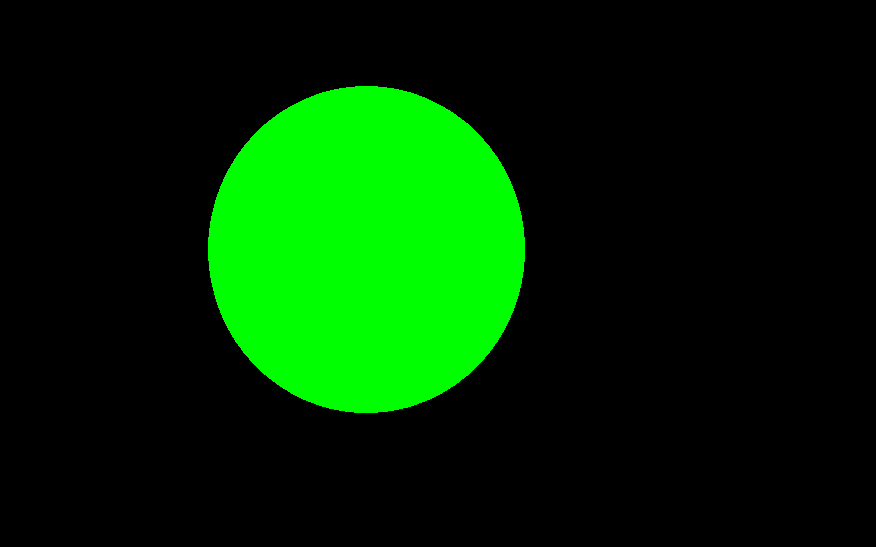

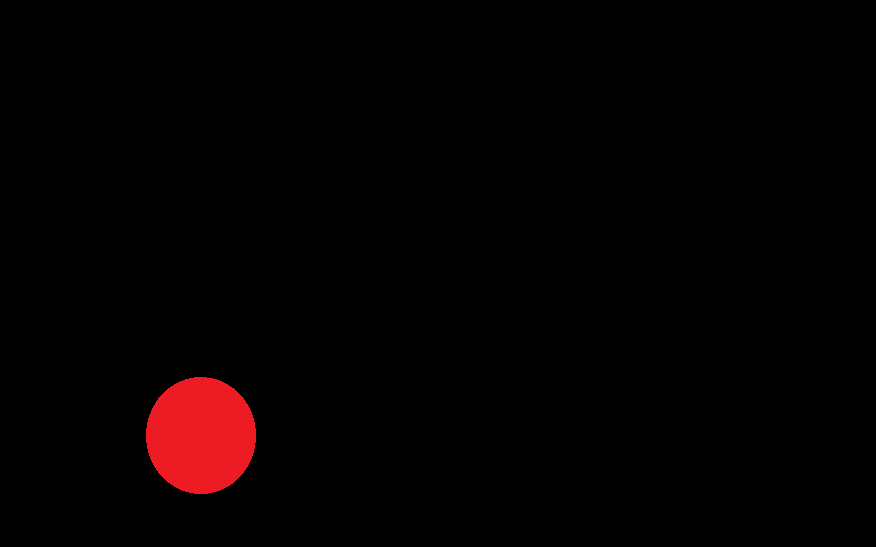

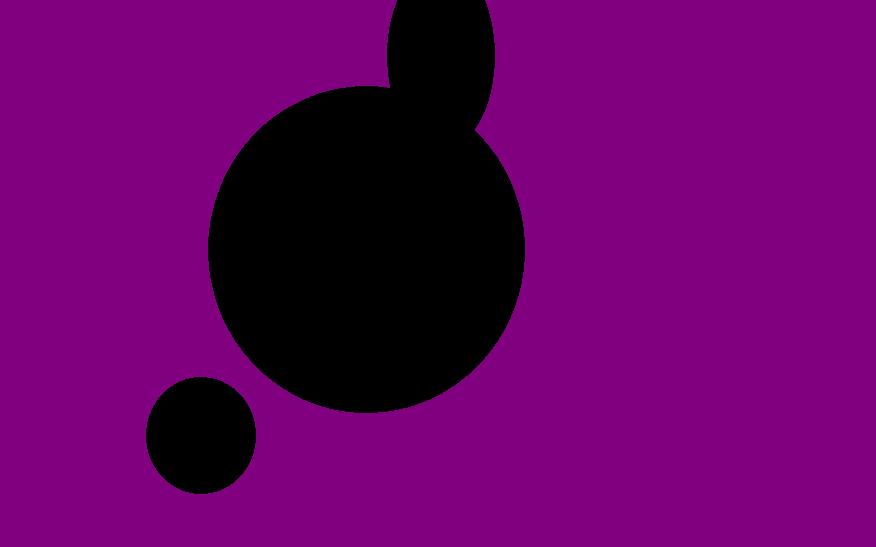

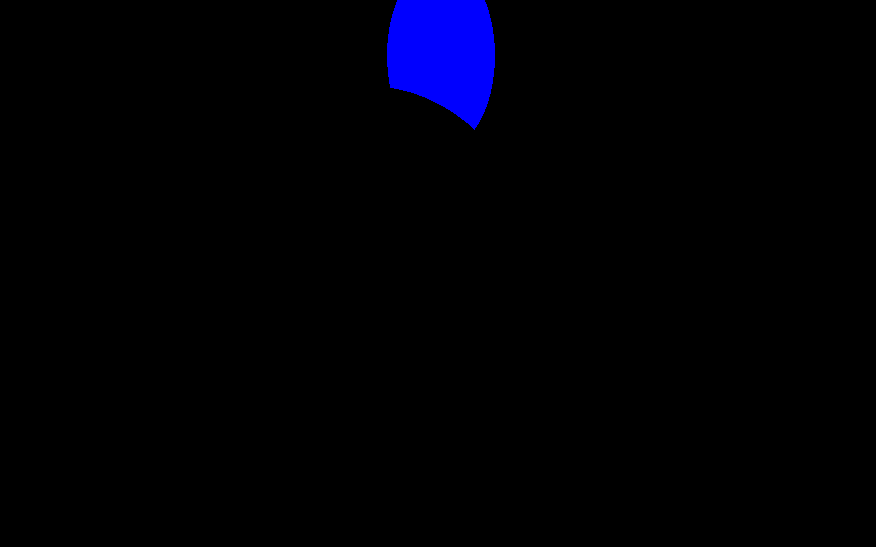

In [9]:
img = cv2.imread('after1.png')

# Convert the image to the RGB color space if it is not already in that format
if len(img.shape) > 2 and img.shape[2] == 4:
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
else:
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

# Calculate the unique colors in the image
unique_colors = np.unique(img.reshape(-1, img.shape[-1]), axis=0)
after_colors = {}

for color in unique_colors:
    for key, value in class_labels.items():
      if (color[0] <= value[0]+40 and color[0] >= value[0]-40 and
          color[1] <= value[1]+40 and color[1] >= value[1]-40 and
          color[2] <= value[2]+40 and color[2] >= value[2]-40).all():
        # Create a binary mask for the current color
        mask = np.where(np.all(img == color, axis=-1), 1, 0)

        # Calculate the area of the mask
        area = np.sum(mask)

        # Apply the binary mask to the input image
        masked_img = img * mask[..., np.newaxis]
        after_colors[key]=[masked_img, area]
        cv2_imshow(masked_img)

lake:


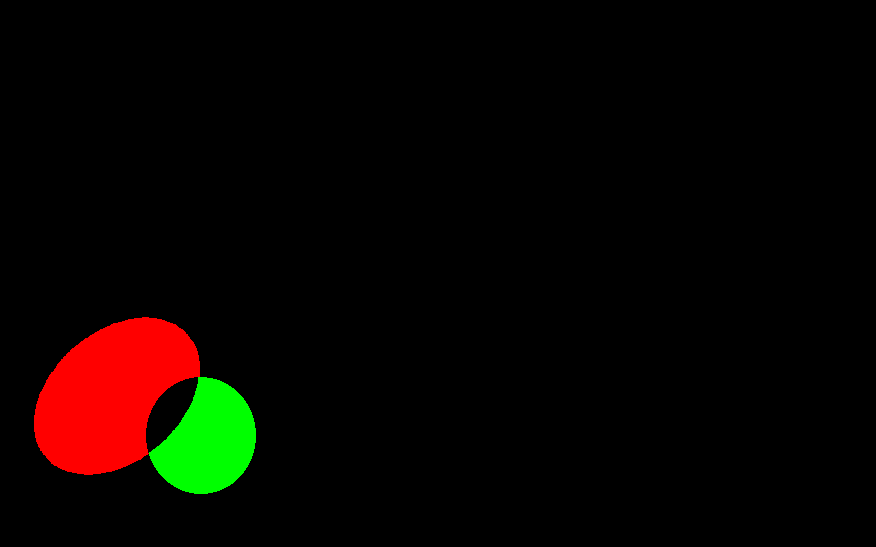

buildings:


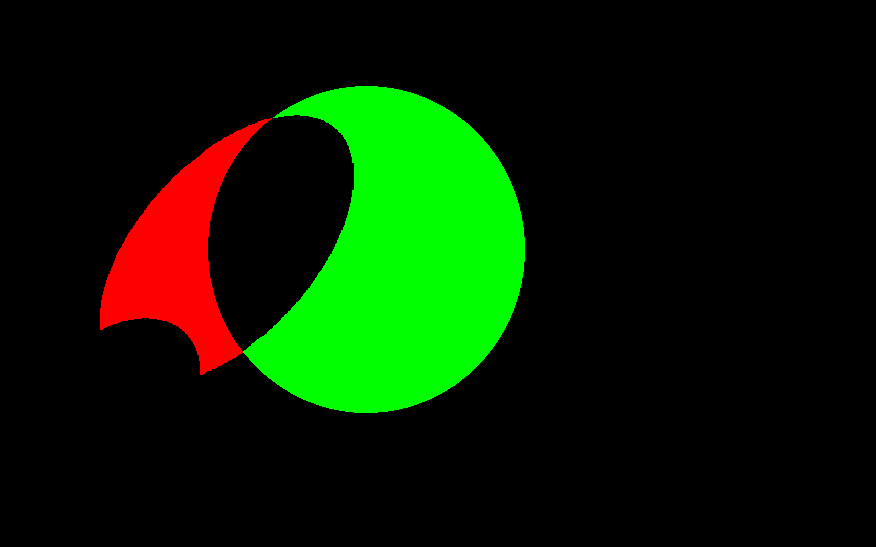

land:


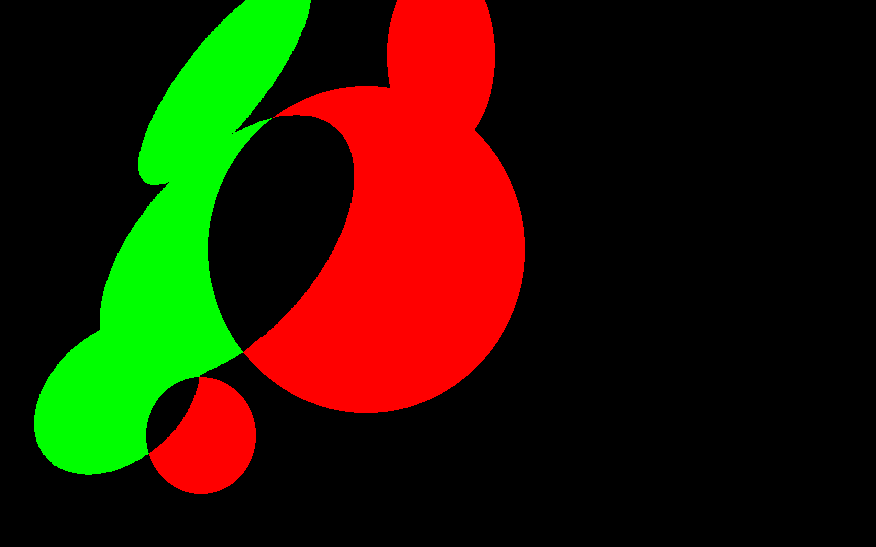

forest:


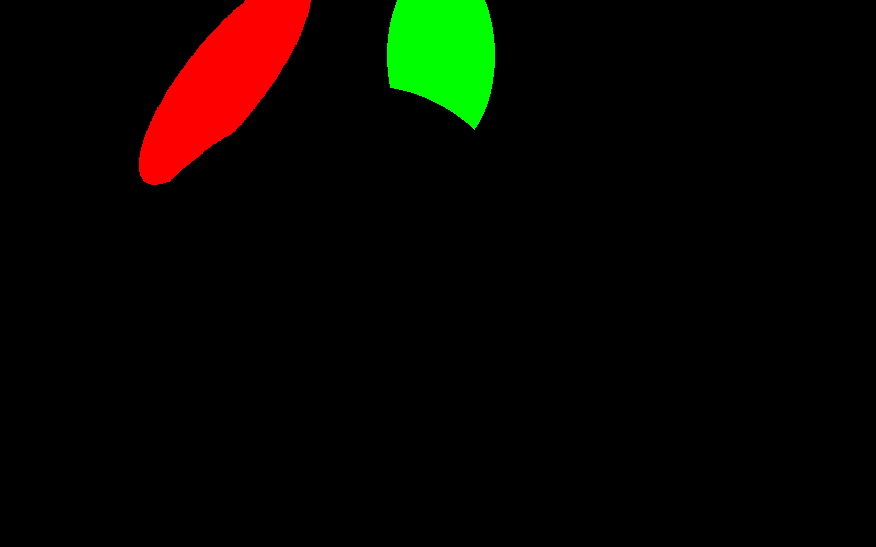

In [10]:
for k1, v1 in before_colors.items():
    for k2, v2 in after_colors.items():
        if k1 == k2:
              img1 = before_colors[k1][0]
              img2 = after_colors[k1][0]
              img1 = cv2.convertScaleAbs(img1)
              img2 = cv2.convertScaleAbs(img2)
              img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
              img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


              # Resize the images to the same size
              img1 = cv2.resize(img1, (img2.shape[1], img2.shape[0]))

              # Subtract one array from the other
              diff1 = img1.astype(np.int16) - img2.astype(np.int16)
              diff2 = img2.astype(np.int16) - img1.astype(np.int16)

              # Create binary masks for the lighter pixels
              mask1 = np.zeros_like(diff1)
              mask2 = np.zeros_like(diff2)
              _, mask1_thresh = cv2.threshold(diff1, 20, 255, cv2.THRESH_BINARY)
              mask1[mask1_thresh == 255] = 255
              _, mask2_thresh = cv2.threshold(diff2, 20, 255, cv2.THRESH_BINARY)
              mask2[mask2_thresh == 255] = 255


              # Create a 3-channel RGB image
              result = np.zeros((diff1.shape[0], diff1.shape[1], 3), dtype=np.uint8)
              # Set the red and green channels to the binary masks
              result[mask1 == 255, 2] = 255
              result[mask2 == 255, 1] = 255
              
              print(f"{k1}:")
              cv2_imshow(result)
              cv2.imwrite(f"{k1}.png", result)
              cv2.waitKey(0)
              cv2.destroyAllWindows()


In [12]:
def compare_images(initial_image, final_image, color, feature, initial_area, final_area):

    initial_image = cv2.convertScaleAbs(initial_image)
    final_image = cv2.convertScaleAbs(final_image)
    initial_image = cv2.resize(initial_image, (final_image.shape[1], final_image.shape[0]))

    initial_gray = cv2.cvtColor(initial_image, cv2.COLOR_BGR2GRAY)
    final_gray = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)

    diff = cv2.absdiff(initial_gray, final_gray)

    color_mask = np.all(final_image == color, axis=-1)

    # Threshold the difference image to find pixels of the desired color
    _, color_mask = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    color_mask = cv2.bitwise_and(color_mask, color_mask, mask=np.uint8(color_mask))

    # Find contours of pixels of the desired color
    contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    area_change = ((final_area - initial_area)/initial_area)*100

    # print(f"{feature}-{color}: Initial area: {initial_area:.2f} square pixels. Final area: {final_area:.2f} square pixels")
    # print(f"{feature}-{color}: Percentage change in area: {area_change:.2f}%")

    return feature, initial_area, final_area, area_change

In [13]:
changes = {}
for k1, v1 in before_colors.items():
  for k2, v2 in after_colors.items():
    if k1 == k2:
      initial_image = before_colors[k1][0]
      final_image = after_colors[k1][0]
      color = class_labels[k1]
      feature, initial_area, final_area, area_change = compare_images(initial_image, final_image, color, k1, before_colors[k1][1], after_colors[k1][1])
      changes[feature] = [round(initial_area,2)*0.25, round(final_area,2)*0.25, area_change]

In [14]:
print(changes)

{'lake': [5112.75, 2525.0, -50.613661923622324], 'buildings': [10682.5, 20336.5, 90.37210390826117], 'land': [108444.0, 94229.0, -13.108147984213051], 'forest': [4077.75, 2702.5, -33.725706578382685]}


In [15]:
def generate_gpt3_response(user_text, print_output=False):
    # print_output: whether or not to print the raw output JSON

    completions = openai.Completion.create(
        engine='text-davinci-003',  # Determines the quality, speed, and cost.
        temperature=0.5,            # Level of creativity in the response
        prompt=user_text,           # What the user typed in
        max_tokens=500,             # Maximum tokens in the prompt AND response
        n=1,                        # The number of completions to generate
        stop=None,                  # An optional setting to control response generation
    )

    # Displaying the output can be helpful if things go wrong
    if print_output:
        print(completions)

    # Return the first choice's text
    return completions.choices[0].text

In [16]:
def gpt_map(coordinates):
  disaster_dict = {(33, -116): "Socal Fire, South California", (38.469140, -122.731547): "Santa Rosa Wildfire, Santa Rosa California", (-0.834806, 119.889349): "Palu Tsunami, Palu Indonesia", (46.187150, -90.670364): "Midwest floods, Midwestern USA", 
                  (18.874770, -101.445760): "Mexico Earthquake, Michoacan Mexico", (28.034882, -80.860251): "Hurricane Micheal, Florida USA", (19.810257, -73.158462): "Hurricane Matthew, Haiti", (29.912784, -92.314043): "Hurricane Harvey, Louisiana USA",
                  (34.925975, -76.997224): "Hurricane Florence, North Carolina", (14.474586, -90.880957): "Guatemala Volcano, Guatemala" }
  for k,v in disaster_dict.items():
    if k==coordinates:
      disaster = v
  user_text = f"For the natural disaster '{disaster} that occured in the coordinates '{coordinates}', describe the environmental and geographical conditions pre and post disaster."
  res1 = generate_gpt3_response(user_text, print_output=False)
  return res1

In [17]:
#plugging in coordinates for guatemala volcano disaster for testing
print(gpt_map((14.474586, -90.880957)))



Pre Disaster:

Geographical Conditions: Guatemala Volcano is located in the Central American country of Guatemala. It is an active stratovolcano located in the department of Escuintla. It is located about 45 kilometers south of the capital city of Guatemala City and has an elevation of 3,763 meters.

Environmental Conditions: Guatemala Volcano is surrounded by lush vegetation and tropical forests. The area is home to a variety of wildlife and plants, including many rare species. The volcano is also surrounded by several villages, which have been impacted by the volcano's eruptions in the past.

Post Disaster:

Geographical Conditions: After the eruption of Guatemala Volcano, the landscape was drastically changed. The volcano erupted with a column of ash that reached heights of up to 20 kilometers. The ash cloud spread across the region and caused widespread destruction. The eruption also caused the formation of several new lava flows and a new crater.

Environmental Conditions: The e

In [18]:
def gpt_both():
  user_text = f"I am providing this python dictionary: {changes}, where the key is the geographical feature and the value is the initial area, final area, and percentage in square meters in order. Describe the dictionary in a paragraph format to describe the value (area changes) for each key (geographical feature). Do not provide the text in a way that it is obvious you are describing a python dictionary. After that, given the data in the dictionary of the area change of each geographical feature in the region, give recommendations on the measures that should be taken in this region to conserve the environment."
  res2 = generate_gpt3_response(user_text, print_output=False)
  return res2

In [19]:
print(gpt_both())



This region has four main geographical features: lake, buildings, land, and forest. The initial area of the lake was 5112.75 square meters, and the final area was 2525.0 square meters, resulting in a decrease of 50.613661923622324 percent. The initial area of the buildings was 10682.5 square meters, and the final area was 20336.5 square meters, resulting in an increase of 90.37210390826117 percent. The initial area of the land was 108444.0 square meters, and the final area was 94229.0 square meters, resulting in a decrease of 13.108147984213051 percent. The initial area of the forest was 4077.75 square meters, and the final area was 2702.5 square meters, resulting in a decrease of 33.725706578382685 percent.

Given the data in the dictionary of the area change of each geographical feature in the region, measures that should be taken in this region to conserve the environment include protecting the remaining lake and forest areas, replanting trees in deforested areas, and limiting dev